# An Introductory Neural Network with JAX
We will now build a relatively basic neural network to classify $28\times28$ images of written characters between zero and nine from the MNIST training set. It's largely derived from the [Training a Simple Neural Network, with PyTorch Data Loading tutorial](https://jax.readthedocs.io/en/latest/notebooks/Neural_Network_and_Data_Loading.html).  The Pytorch data loading has been cut out, though.

Let's load the data.

In [154]:
import jax.numpy as jnp
import jax 

import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
import gzip
import pickle
import time

# Download from here if you must: https://github.com/pytorch/tutorials/blob/main/_static/mnist.pkl.gz
mnist_path = Path('data') / 'mnist' / 'mnist.pkl.gz'

with gzip.open(mnist_path, 'rb') as f:
    data = pickle.load(f, encoding='latin-1')

# First, split the data set into training and validation subsets.
train_d = tuple(map(jnp.array, data[0]))
valid_d = tuple(map(jnp.array, data[1]))


Each subset is a tuple of length 2.  The first component is a 2D array where each row is a flattened image.  The second component is a 1D arry of integers, each corresponding to a row in the first component.  These integers are the labels. 

We are going to optimze a function $y_i=f(\mathbf{x}_i|\mathbf{\theta})$, where $\mathbf{x}_i$ is the $i^{th}$ row of the input data array and $y_i$ is its corresponding label. $\mathbf{\theta}$ is a vector of parameters to optimize, which will then provide a good approximation of unknown true classifier function. 

Before we do this, let's transform the label vector into a label array of zeros and ones via one-hot encoding. The idea is pretty straightfoward.  Each row of the new label array will be a length-$10$ vector (recall, all data has ten possible labels) with all components set to zeros except for the index correspondinging to the initial label vector's integer value.  Consider a binary classification example (so only two possible labels) on a data set with three elements.  The one-hot encoding would look like this:

$\begin{bmatrix} 1 \\ 2 \\ 2\end{bmatrix}\rightarrow \begin{bmatrix}1 & 0\\0 & 1\\ 0 & 1 \end{bmatrix}$.

In [155]:
test_labels = jnp.array([0, 2, 3, 2, 1, 2])

# Luckily, JAX has a built in one-hot transformation function.
onehot_test_labels = jax.nn.one_hot(test_labels, 4)

# Let's see what the test looks like.
jnp.expand_dims(test_labels, (1,)), onehot_test_labels

(DeviceArray([[0],
              [2],
              [3],
              [2],
              [1],
              [2]], dtype=int32),
 DeviceArray([[1., 0., 0., 0.],
              [0., 0., 1., 0.],
              [0., 0., 0., 1.],
              [0., 0., 1., 0.],
              [0., 1., 0., 0.],
              [0., 0., 1., 0.]], dtype=float32))

In [156]:
# Organize data into training/validation input and output pairs.
train_in = train_d[0]
train_out = jax.nn.one_hot(train_d[1], jnp.max(train_d[1]) + 1)
valid_in = valid_d[0]
valid_out = jax.nn.one_hot(valid_d[1], jnp.max(valid_d[1]) + 1)

## Autobatching the Data
Batches of `bs=100` images will be fed through the network at a time during training.  Let's write a function that will autobatch the image-label pairs, because right now the format is for one large batch with `bs=len(train_in)`.

In [157]:
def autobatch(x, y, bs):
    n_data = len(x)
    n_b = n_data // bs
    x_b = [x[i * bs:(i + 1) * bs] for i in range(n_b - 1)]
    y_b = [y[i * bs:(i + 1) * bs] for i in range(n_b - 1)]

    if n_data % bs:
        x_b.append(x[n_b * bs:])
        y_b.append(y[n_b * bs:])
    return zip(x_b, y_b)

# Test to make sure it works. 
for x, y in autobatch(train_in[:40], train_out[:40], 10):
    print(x.shape, y.shape)

(10, 784) (10, 10)
(10, 784) (10, 10)
(10, 784) (10, 10)


## Neural Network Machinery and Random Keys
The mapping between layers is linear, which means for an input $\mathbf{x}\in \mathcal{R}^n$, the layer output $\mathbf{y}\in\mathcal{R}^m$ is a linear transformation $\mathbf{y}=\mathbf{W}\mathbf{x}+\mathbf{b}$.  The $n\times m$ matrix $\mathbf{W}$ contain the layer's weight parameters, and the length-$m$ vector $\mathbf{b}$ contain its bias parameters. This model will have three such layers: an input layer, a hidden layer, and an output layer. 

We are going to create some helper functions to instantiate layers of this neural network.  To do so requires some JAX-style random number generation.  

Recall that JAX handles (pseudo)random number generators a little differentt than numpy or scipy.  You need to provide a random seed (or key in JAX nomenclature) for reach random object that is instantiated.  If you keep reusing the same key, though, you'll just get the same 'random' numbers over and over, though.  This is where `jax.random.split` comes to the rescue.  

In a JAX workflow, a random key is first fed into `jax.random.split`, which returns a tuple of new keys `(key, subkey)`.  The recommended workflow is to feed `subkey` into a random number generator and forget about it, and use `key` to the generate a new pair from another `jax.random.split` call.  There is more information about this via a [tutorial](https://jax.readthedocs.io/en/latest/jax-101/05-random-numbers.html).

First thing to do is to define a function that returns weights and biases for a network layer.  We'll have to instantiate some random JAX arrays to do this.

In [158]:
# This returns weights and biases for a dense neural network layer.
def random_layer_params(key, m, n, scale=1e-2):
    # Let's cheat a bit --- we don't need to keep the new key, so let's feed it into
    # one of the two returned JAX arrays.
    weight_key, bias_key = jax.random.split(key)
    return scale * jax.random.normal(weight_key, (n, m)), scale * jax.random.normal(bias_key, (n,))


# This returns an instantiated list of weights and biases.
def init_network_params(key, sizes):
    # We need a key for each layer. We get multiple (key,subkey) pairs providing an integer.
    keys = jax.random.split(key, len(sizes))
    return [random_layer_params(k, m, n) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]


## Building the Model
A neural network needs activation functions between its layers.  Here, an ReLU nonlinear activation function will be used.  ReLU is a  straightforward piecewise function:

$\text{ReLU}(x)=\begin{cases} x & x\geq 0 \\ 0 & x<0 \end{cases}$.

It can also be thought of as a maximum comparison function where an input is compared to zero.  

We also want to define a function that returns a prediction for a single input image. Because there are multiple layers, we activate each layer starting with the input image as the activation, transform it via the first layer, and redefine the activation as this layer's output, and then feed in the new activation into the next layer. This process is continued until all layers are used an a final output is provided. 

In [159]:
layer_sizes = [28 * 28, 512, 512, 10] # network layer sizes
test_params = init_network_params(jax.random.PRNGKey(99), layer_sizes)

def ReLU(x):
    return jnp.maximum(0., x)

def prediction(params, image):
    activation = image
    for w, b in params[:-1]:
        output = jnp.dot(w, activation) + b
        activation = ReLU(output) 
    
    # We don't want to run the output through the activation function.
    w_final, b_final = params[-1]
    logits = jnp.dot(w_final, activation) + b_final
    # print(logits, jax.scipy.special.logsumexp(logits))
    return logits - jax.scipy.special.logsumexp(logits)

# Let's test on a random 28x28 image.
test_image = jax.random.normal(jax.random.PRNGKey(1), (28 * 28,))
test_pred = prediction(test_params, test_image)
print(test_image.shape, test_pred.shape)

(784,) (10,)


Let's step back and decipher what is going on in `prediction`.  In the first step, we define a new variable `activation` and feed it through the respective layers of the neural network, updating the activation input at the end of each iteration.  The last layer defines the output, which is called `logits`, which can be interpreted as an unnormalized score.  

We do not return the `logits` array, though.  It is normalized by subtracting `logsumexp(logits)` to improve numerical stability!

## Vectorizing `Prediction`
JAX provides a useful transformations `vmap` to vectorize functions.  This will be convenient, since batches of training data will be fed into the `prediction` function.  [A more elementary JAX tutorial](https://jax.readthedocs.io/en/latest/jax-101/03-vectorization.html) introduces how and why to use `vmap`, but in summary, vectorized operations offer superior performance to loops in python.  By vectorizing the `for`-loop in `prediction` with `vmap`, we get a performance boost without having to smash our head against the wall figuring out how to vectorize it directly! 

We also want the vectorized `prediction` function to handle batched inputs.  Per epoch, each training iteration will take a batch of 100 images.  Vectorizing `prediction` to accomodate this will make life easier.  Let's explore some examples before applying it to `prediction`.

In [160]:
# Let's vectorize a sum function.
def s(x1, x2):
    return x1 + x2

# Let's sum two vectors element-wise.
x = jnp.array([1., 2.])
y = jnp.array([3., 4.])
s_vmap = jax.vmap(s, in_axes=(0, 0))
print(s_vmap(x, y)) # looks good.


[4. 6.]


In [161]:
# What happens when we try to sum two matrices with s_vmap.
a = jnp.array([[1., 2.], [3., 4.]])
b = jnp.array([[5., 6.], [7., 8.]])
print(s_vmap(a, b)) # looks good. 

[[ 6.  8.]
 [10. 12.]]


In [162]:
# We can change is to the first argument is ignored.
s_vmap_2 = jax.vmap(s, in_axes=(None, 0))
# Now, the first argument is being held fixed as an input array while the second is iterated over.
# That means we get an output of two vectors: [1, 2] + 3 and [1, 2] + 4.
print(s_vmap_2(x, y)) # looks good. 

[[4. 5.]
 [5. 6.]]


In [163]:
# That means s_vmap_2(x, a) should yield a 2x2 matrix: [1, 2] + [1, 2] and [1, 2] + [3, 4].
print(s_vmap_2(x, a)) # looks good. 

[[2. 4.]
 [4. 6.]]


The vectorized `prediction` function should leave the first argument fixed because only images need to be interated over with a vectorized function.  That means `in_axes=(None, 0)` will provide the correct functionality.

Some utility functions will also come in handy.  In particular, we want an accuracy calculator, a loss function, and a function to update parameters via gradient descent.  

In [173]:
test_images = jax.random.normal(jax.random.PRNGKey(42), (10, 28 * 28))
test_labels = jax.nn.one_hot(
    jax.random.randint(jax.random.PRNGKey(42), (10,), minval=0, maxval=9),
    10
)
batched_prediction = jax.vmap(prediction, in_axes=(None, 0))

def accuracy(params, images, true_labels):
    pred_class = jnp.argmax(batched_prediction(params, images), axis=1)
    true_class = jnp.argmax(true_labels, axis=1)
    return jnp.mean(pred_class == true_class)

def loss(params, images, true_labels):
    pred = batched_prediction(params, images)
    # print(pred, true_labels)
    return -jnp.mean(pred * true_labels) # cross entropy

# Decorate the update function so that it is JIT-ified.
@jax.jit
def update(params, x, y):
    gradients = jax.grad(loss)(params, x, y) # This is a tuple
    return [(w - dw * lr, b - db * lr) for (w, b), (dw, db) in zip(params, gradients)]


### Digesting `update`
That last function has a lot going on in the return statement.  What we are doing is calculating the gradient of the loss function with respect to the model parameters.  Remember that the argument `params` is a tuple `(weights, bias)`, so the gradient of the loss w.r.t. `params` is also a tuple.  The return value is a list where the parameters are adjusted by their respective gradients multiplied by the learning rate `lr`. 

## Training the Model
Let's train.  First, plot an image from and its label.

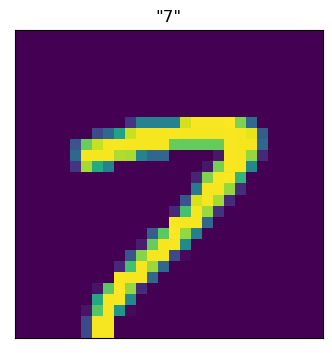

In [174]:
plt.figure(figsize=(4,4))
test_index = 123
plt.imshow(train_in[test_index].reshape((28, 28))) # Remember, we flattend the images before!
label = jnp.argmax(train_out[test_index])
plt.title(f'"{label}"')
plt.xticks([])
plt.yticks([])
plt.show()

## The Training Loop

In [190]:
init_key = jax.random.PRNGKey(11) # get a key to start with.

# These are the constants we need for the model.
layer_sizes = [28 * 28, 512, 512, 10] # network layer sizes
lr = 10. # Learning rate for gradient descent
n_epochs = 5 # Number of times to feed data through the network during training
bs = 100 # Size of batches to send through network per forward pass
n_targets = 10 # Number of labels

# Instantiate parameters. 
params = init_network_params(init_key, layer_sizes)

# Loop to train parameters.  Print out some useful information along the way. 
for epoch in range(n_epochs):
    start_time = time.time()
    for images, labels in autobatch(train_in, train_out, bs):
        params = update(params, images, labels)

    # Info to print.
    epoch_time = time.time() - start_time
    train_accuracy = accuracy(params, train_in, train_out)
    train_loss = loss(params, train_in, train_out)
    validation_accuracy = accuracy(params, valid_in, valid_out)
    validation_loss = loss(params, valid_in, valid_out)
    print(f'Epoch {epoch} time: {epoch_time:.3f} seconds.')
    print(f'Training sample accuracy: {train_accuracy:.3f}.  Training loss: {train_loss:.3f}.')
    print(f'Validation sample accuracy: {validation_accuracy:.3f}.  Validation loss: {validation_loss:.3f}.')

Epoch 0 time: 2.202 seconds.
Training sample accuracy: 0.859.  Training loss: 0.045.
Validation sample accuracy: 0.875.  Validation loss: 0.042.
Epoch 1 time: 2.020 seconds.
Training sample accuracy: 0.912.  Training loss: 0.030.
Validation sample accuracy: 0.920.  Validation loss: 0.027.
Epoch 2 time: 2.006 seconds.
Training sample accuracy: 0.939.  Training loss: 0.021.
Validation sample accuracy: 0.945.  Validation loss: 0.019.
Epoch 3 time: 2.028 seconds.
Training sample accuracy: 0.955.  Training loss: 0.015.
Validation sample accuracy: 0.957.  Validation loss: 0.015.
Epoch 4 time: 2.011 seconds.
Training sample accuracy: 0.964.  Training loss: 0.012.
Validation sample accuracy: 0.964.  Validation loss: 0.013.


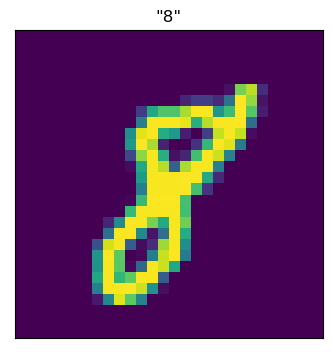

Prediction label: 8


In [188]:
# Let's dispay a test image and print out the predicted label.
plt.figure(figsize=(4,4))
test_index = 17
plt.imshow(train_in[test_index].reshape((28, 28))) # Remember, we flattend the images before!
label = jnp.argmax(train_out[test_index])
plt.title(f'"{label}"')
plt.xticks([])
plt.yticks([])
plt.show()
print('Prediction label:', jnp.argmax(prediction(params, train_in[test_index])))

## Getting Label Probabilities
The model is trained, but its output predictions are not probabilities for each label. All that needs to be done is a renormalization that makes sure the predicted label values sum to one and are all positive.  Luckily, the softmax function does just this.

$\text{SoftMax}(x_i)=\frac{e^{x_i}}{\sum_{j=1}^n e^{x_j}}$

Here, $x_i\in\mathbf{x}$ is a length-$n$ vector.  This mapping preserves order, but normalizes the sum to unity.  It's exactly what we need.

In [189]:
test_output = prediction(params, train_in[test_index])

print(jnp.sum(test_output)) # this does not sum to 1.
print()

def softmax(x):
    return jnp.exp(x) / jnp.sum(jnp.exp(x))

test_probs = softmax(test_output)
print(jnp.sum(test_probs)) # we now have label probabilities

test_probs

-95.2064

1.0


DeviceArray([5.2680139e-07, 5.1918620e-04, 8.2599627e-06, 6.8638896e-05,
             7.4309787e-06, 5.0259236e-04, 8.4428245e-07, 8.8851048e-06,
             9.9784762e-01, 1.0360671e-03], dtype=float32)